In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import sys
import os
import lmfit
from scipy import special
import function as func
import fit_script as fit

In [4]:
if __name__ == "__main__":
    
    check_freq = np.array([18190, 18336, 19120, 19186, 19440, 19478, 19766, 19794, 19818, 20006, 20296, 20302, 20490, 20540, 20892, 21442, 21808, 22522, 22672, 23306, 23808, 23934, 25328, 25352, 25860, 26274, 26346])
    
    #start_freq = 26.4
    #print(start_freq)
    #initial = int(start_freq * 1.e+6 - 250)
    #final = int(initial + 1.e+5)
    
    for i in check_freq:
        word = list(str(i*1000 - 250))
        word.insert(2, ".")
        start = "".join(word)
        print(f'start = {start}')
        
        start_freq = (i//100)*100 # MHz
        start_freq *= 1e-3 # GHz
        start_freq = round(start_freq, 6)
        print(f'start_freq = {start_freq}')

        signal = func.csv_to_array("/data/ms2840a/result_data/check_result/signal_12_data/start_{}GHz.csv".format(start))
        W1 = (signal["W_0"] + signal["W_1"] + signal["W_2"] + signal["W_3"] + signal["W_4"] + signal["W_5"] + signal["W_6"] + signal["W_7"] + signal["W_8"] + signal["W_9"] + signal["W_10"] + signal["W_11"])/12 

        signal = func.csv_to_array("/data/ms2840a/result_data/signal_12_data/start_{}GHz.csv".format(start))
        W2 = (signal["W_0"] + signal["W_1"] + signal["W_2"] + signal["W_3"] + signal["W_4"] + signal["W_5"] + signal["W_6"] + signal["W_7"] + signal["W_8"] + signal["W_9"] + signal["W_10"] + signal["W_11"])/12 

        
        # W1 is averaged 10 times more than W2 (W1 measurement time is 10 times more than W2.)
        freq, W, W_err = func.rebin_func(signal["freq"], (W1+W2/10)/1.1) 
        # Save to csv file
        column = ['freq', 'W', 'W_err']
        with open("/data/ms2840a/result_data/check_result/signal_mean_W/start_{}GHz.csv".format(start), "w") as f:
            writer = csv.writer(f)
            writer.writerow(column)
            for j in range(len(freq)):
                writer.writerow([freq[j], W[j], W_err[j]])
                pass
            pass

        # path for fit result on W1(additional measurement)+W2
        path = "/data/ms2840a/result_data/check_result/fit_result_mean_W_test/start_{}GHz.csv".format(start)

        fit.fitting(path, start, start_freq, freq, W)
        pass

start = 18.189750
start_freq = 18.1
start_col = 90000000.0
start = 18.335750
start_freq = 18.3
start_col = 36000000.0
start = 19.119750
start_freq = 19.1
start_col = 20000000.0
start = 19.185750
start_freq = 19.1
start_col = 86000000.0
start = 19.439750
start_freq = 19.4
start_col = 40000000.0
start = 19.477750
start_freq = 19.4
start_col = 78000000.0
start = 19.765750
start_freq = 19.7
start_col = 66000000.0
start = 19.793750
start_freq = 19.7
start_col = 94000000.0
start = 19.817750
start_freq = 19.8
start_col = 18000000.0
start = 20.005750
start_freq = 20.0
start_col = 6000000.0
start = 20.295750
start_freq = 20.2
start_col = 96000000.0
start = 20.301750
start_freq = 20.3
start_col = 2000000.0
start = 20.489750
start_freq = 20.4
start_col = 90000000.0
start = 20.539750
start_freq = 20.5
start_col = 40000000.0
start = 20.891750
start_freq = 20.8
start_col = 92000000.0
start = 21.441750
start_freq = 21.4
start_col = 42000000.0
start = 21.807750
start_freq = 21.8
start_col = 8000000.0


# Fit with a specific frequency span (2MHz) for check

In [2]:
outdir = './plot/result_figure/fit_result'
if not os.path.isdir(outdir):
    os.makedirs(outdir)
    pass

In [3]:
# freq0: Hz 
def fit_one(freq0, dfreq_0=0, verbose=1):
    print(f'*** Fit at frequency = {freq0*1.e-9} GHz ***')
    n_data = 12 # number of measurements
    data_time = 2. # [sec] time for nominal data
    data_time2 = 20. # [sec] time for additional data
    freq0_MHz = freq0*1e-6
    
    # additional data [MHz]
    check_freq = np.array(
        [18190, 18336, 19120, 19186, 19440, 19478, 19766, 19794, 19818, 20006, 
         20296, 20302, 20490, 20540, 20892, 21442, 21808, 22522, 22672, 23306, 
         23808, 23934, 25328, 25352, 25860, 26274, 26346])
    
    is_add_data = False
    for _check_freq in check_freq:
        # Check if freq0 is in 2MHz measured data span in additional datas
        if _check_freq <= freq0_MHz and freq0_MHz < _check_freq + 2.:
            is_add_data = True
            pass
        pass
    print('This frequency has an additional data? -->', is_add_data)
    
    
    # Get start freq of 100MHz span
    start_100MHz = (freq0_MHz//100)*100 # MHz (100MHz 毎にする)
    start_100MHz *= 1e-3 # GHz
    start_100MHz = round(start_100MHz, 6) # GHz で小数点以下6桁(kHz)までにする
    print(f'start_100MHz = {start_100MHz} GHz')
    
    # Get start freq of 2MHz span
    start_2MHz = (freq0_MHz//2)*2 # MHz (2MHz 毎にする)
    start_2MHz *= 1e-3 # GHz
    start_2MHz = round(start_2MHz, 6) # GHz で小数点以下6桁(kHz)までにする
    print(f'start_2MHz = {start_2MHz} GHz')
    
    # Get start freq of data span (start_2MHz - 0.25 MHz)
    start = start_2MHz - 0.00025
    start = round(start, 6) # GHz で小数点以下6桁(kHz)までにする
    start_str = f'{start:.06f}'
    print(f'start_str = {start_str}')

    signal = func.csv_to_array("/data/ms2840a/result_data/signal_12_data/start_{}GHz.csv".format(start_str))
    freq = signal['freq']
    keys_W = [ f'W_{i}' for i in range(n_data) ]
    W_array = np.array([ signal[key] for key in keys_W ])
    W = np.average(W_array, axis=0) # mean of (W_0, W_1,... W_{n_data})
    if verbose > 0:
        print(f'data keys = {signal.keys()}')
        print(f'power keys = {keys_W}')
        print(f'freq (size={len(freq)}) = ',freq)
        print(f'W (nominal data, size={len(W)}) = ',W)
        pass

    # Add the additional data
    W_add = W
    if is_add_data:
        signal2 = func.csv_to_array("/data/ms2840a/result_data/check_result/signal_12_data/start_{}GHz.csv".format(start_str))
        freq2 = signal2['freq']
        W2_array = np.array([ signal2[key] for key in keys_W ])
        W2 = np.average(W2_array, axis=0) # mean of (W_0, W_1,... W_{n_data})
        print(f'additional data keys = {signal.keys()}')
        print('W2 (additional data) = ', W2)
        
        # W2 is averaged 10 times more than W (W2 measurement time is 10 times more than W.)
        W_add = (W*data_time+W2*data_time2)/(data_time+data_time2)
        pass
    
    # Rebinning to 2kHz bins
    freq_rebin, W_rebin, W_rebin_err = func.rebin_func(freq, W_add)
    if verbose > 0:
        print(f'freq_rebin (size:{len(freq_rebin)} = {freq_rebin}')
        print(f'W_rebin (size:{len(W_rebin)} = {W_rebin}')
        pass
    
    path='' # No save
    result_list = fit.fitting(path, start=start, start_freq=start_100MHz, freq=freq_rebin, signal=W_rebin, dfreq_0=dfreq_0)
    freq_0 = np.array(result_list['freq_0'])
    if verbose > 0:
        print(f'result keys = {result_list.keys()}')
        print(f'result freq_0 size:{len(freq_0)}')
        pass
    
    return result_list

In [10]:
# Fit with nominal data
#result_list = fit_one(18e+9)

# Fit with nominal data + additional data
#result_list = fit_one(18e+9+190533e+3)

## Check fit variation by changing the peak frequency in Data (NOT USED)

In [15]:
# Change the peak frequency freq_0
dfreq_0 = 1e+3 # [Hz] peak frequency variation
def get_variation_freq0(freq0=18e+9, verbose=0):
    result_list = fit_one(freq0, dfreq_0=0, verbose=0)
    result_list_up = fit_one(freq0, dfreq_0=dfreq_0, verbose=0)
    result_list_down = fit_one(freq0, dfreq_0=-dfreq_0, verbose=0)
    return result_list, result_list_up, result_list_down

def check_variation_freq0(freq0, result_list, result_list_up, result_list_down):
    freq = np.array(result_list['freq_0'])*1e-3 # kHz
    freq_up = np.array(result_list_up['freq_0'])*1e-3 # kHz
    freq_down = np.array(result_list_down['freq_0'])*1e-3 # kHz
    to_aW = 1e+18
    P = np.array(result_list['P'])*to_aW
    P_up = np.array(result_list_up['P'])*to_aW
    P_down = np.array(result_list_down['P'])*to_aW

    dP = np.std(P)
    diff_up = P_up - P
    diff_down = P_down - P
    std_diff_up = np.std(diff_up)
    std_diff_down = np.std(diff_down)
    std_diff_ave = (std_diff_up + std_diff_down)/2.
    diffratio_up = diff_up/dP
    diffratio_down = diff_down/dP
    print(f'Mean. of diff up   = {np.mean(diff_up):f} aW')
    print(f'Mean. of diff down = {np.mean(diff_down):f} aW')
    print(f'Std.. of diff up   = {std_diff_up:f} aW')
    print(f'Std.. of diff down = {std_diff_down:f} aW')
    print(f'Averaged Std.. of diff = {std_diff_ave:f} aW')
    print(f'Mean. of diffratio up   = {np.mean(diffratio_up)*100.:.3f} %')
    print(f'Mean. of diffratio down = {np.mean(diffratio_down)*100.:.3f} %')
    print(f'Std. of diffratio up   = {np.std(diffratio_up)*100.:.3f} %')
    print(f'Std. of diffratio down = {np.std(diffratio_down)*100.:.3f} %')

    # Frequency Plot
    plt.rcParams["font.size"] = 24
    fig, axes = plt.subplots(3,1,figsize=(20,12), squeeze=False, sharex=False)
    fig.tight_layout()

    ax = axes[0][0]
    ax.scatter(freq, P, s=5, color="black", label="Nominal")
    ax.scatter(freq, P_up, s=5, color="tab:red", label=f"Up (-{dfreq_0*1e-3:.1f} kHz)")
    ax.scatter(freq, P_down, s=5, color="tab:blue", label=f"Down (+{dfreq_0*1e-3:.1f} kHz)")
    ax.set_ylabel(r'$P_\mathrm{DP}$ [aW]')
    ax.set_title(r"$P_{\rm{DP}}$ [aW]")
    ax.legend()
    ax.grid()

    ax = axes[1][0]
    ax.scatter(freq, diff_up, s=5, color="tab:red", label="Up")
    ax.scatter(freq, diff_down, s=5, color="tab:blue", label="Down")
    ax.set_ylabel(r'Difference of $P_\mathrm{DP}$ [aW]')
    ax.set_title(r"Difference of $P_{\rm{DP}}$ [aW]")
    ax.legend()
    ax.grid()
    
    '''
    ax = axes[2][0]
    ax.scatter(freq, diffratio_up, s=5, color="tab:red", label="Up")
    ax.scatter(freq, diffratio_down, s=5, color="tab:blue", label="Down")
    ax.set_ylabel(r'Difference ratio of $P_\mathrm{DP}$ [aW]')
    ax.set_title(r"Difference ratio of $P_{\rm{DP}}$ [aW]")
    ax.set_ylim(-1,1)
    ax.set_yticks([-1.0, -0.5, -0.1, 0, 0.1, 0.5, 1.0])
    ax.legend()
    ax.grid()
    '''

    ax.set_xlabel(r"Frequency [kHz]")
                  
    fig.subplots_adjust(hspace=0.4, left=0.10, right=0.95, bottom=0.0, top=0.95)

    save_file = f"{outdir}/check_freq0_variation_{freq0*1e-9}GHz.pdf"
    fig.savefig(save_file)
    
    # Histogram Plot
    plt.rcParams["font.size"] = 24
    fig, axes = plt.subplots(1,3,figsize=(20,6), squeeze=False, sharex=False)
    fig.tight_layout()

    ax = axes[0][0]
    nbin=50
    ax.hist(P,  bins=nbin, label="Nominal", histtype='step')
    ax.hist(P_up,  bins=nbin, label=f"Up (-{dfreq_0*1e-3:.1f} kHz)", histtype='step')
    ax.hist(P_down,  bins=nbin, label=f"Down (+{dfreq_0*1e-3:.1f} kHz)", histtype='step')
    ax.set_xlabel(r'$P_\mathrm{DP}$ [aW]')
    ax.set_title(r"$P_{\rm{DP}}$ [aW]")
    ax.legend()
    ax.grid()

    ax = axes[0][1]
    ax.hist(diff_up,  bins=nbin, label=f"Up", histtype='step')
    ax.hist(diff_down,  bins=nbin, label=f"Down", histtype='step')
    ax.set_xlabel(r'Difference of $P_\mathrm{DP}$ [aW]')
    ax.set_title(r"Difference of $P_{\rm{DP}}$ [aW]")
    ax.legend()
    ax.grid()
    
    '''
    ax = axes[0][2]
    ax.hist(diffratio_up,  bins=nbin, label=f"Up", histtype='step')
    ax.hist(diffratio_down,  bins=nbin, label=f"Down", histtype='step')
    ax.set_xlabel(r'Difference ratio of $P_\mathrm{DP}$ [aW]')
    ax.set_title(r"Difference ratio of $P_{\rm{DP}}$ [aW]")
    ax.legend()
    ax.grid()
    '''
                  
    fig.subplots_adjust(hspace=0.4, left=0.10, right=0.95, bottom=0.0, top=0.95)

    save_file = f"{outdir}/check_freq0_variation_hist_{freq0*1e-9}GHz.pdf"
    fig.savefig(save_file)
 
    return std_diff_ave/to_aW # [W]

In [6]:
freq0 = 18e+9
nom, up, down = get_variation_freq0(freq0=freq0, verbose=0)

*** Fit at frequency = 18.0 GHz ***
This frequency has an additional data? --> False
start_100MHz = 18.0 GHz
start_2MHz = 18.0 GHz
start_str = 17.999750
start_col = 0.0
*** Fit at frequency = 18.0 GHz ***
This frequency has an additional data? --> False
start_100MHz = 18.0 GHz
start_2MHz = 18.0 GHz
start_str = 17.999750
start_col = 0.0
*** Fit at frequency = 18.0 GHz ***
This frequency has an additional data? --> False
start_100MHz = 18.0 GHz
start_2MHz = 18.0 GHz
start_str = 17.999750
start_col = 0.0


Mean. of diff up   = 0.000083 aW
Mean. of diff down = 0.000040 aW
Std.. of diff up   = 0.003852 aW
Std.. of diff down = 0.003278 aW
Averaged Std.. of diff = 0.003565 aW
Mean. of diffratio up   = 0.418 %
Mean. of diffratio down = 0.202 %
Std. of diffratio up   = 19.479 %
Std. of diffratio down = 16.576 %
Error of P_DP = 3.565079804500539e-21 aW at 17999999991.0 GHz


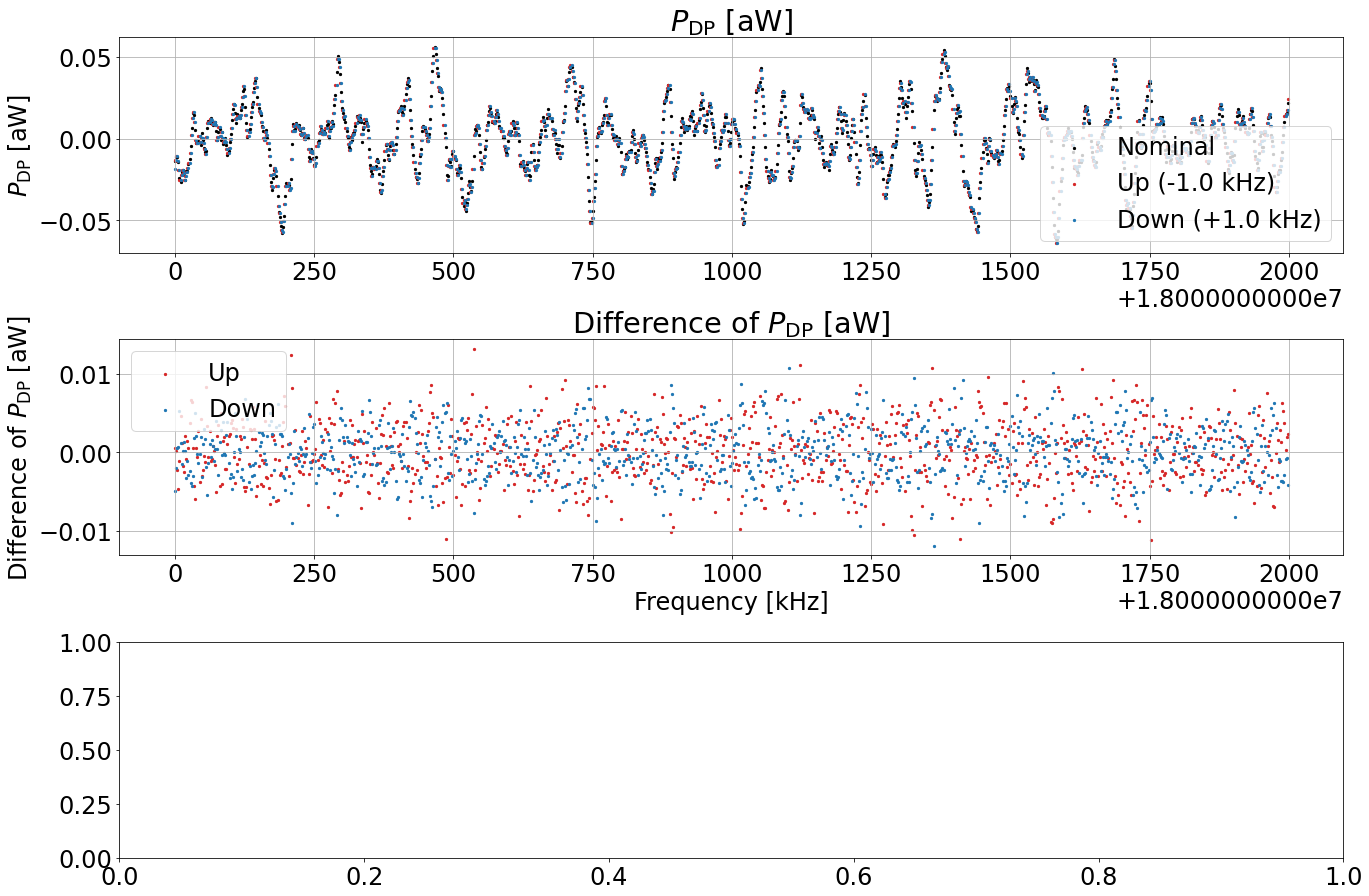

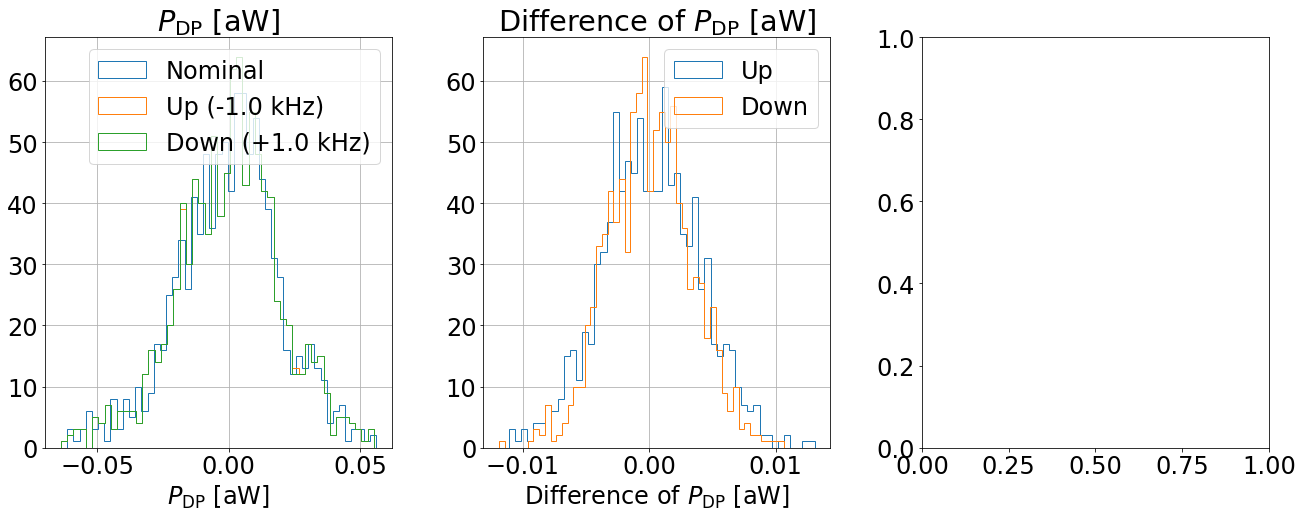

In [16]:
err_P_DP = check_variation_freq0(freq0, nom, up, down)
print(f'Error of P_DP = {err_P_DP} aW at {freq0*1-9} GHz')

In [13]:
freq2 = 26.5e+9-2.e+6
nom2, up2, down2 = get_variation_freq0(freq0=freq2, verbose=0)

*** Fit at frequency = 26.498 GHz ***
This frequency has an additional data? --> False
start_100MHz = 26.4 GHz
start_2MHz = 26.498 GHz
start_str = 26.497750
start_col = 98000000.0
*** Fit at frequency = 26.498 GHz ***
This frequency has an additional data? --> False
start_100MHz = 26.4 GHz
start_2MHz = 26.498 GHz
start_str = 26.497750
start_col = 98000000.0
*** Fit at frequency = 26.498 GHz ***
This frequency has an additional data? --> False
start_100MHz = 26.4 GHz
start_2MHz = 26.498 GHz
start_str = 26.497750
start_col = 98000000.0


Mean. of diff up   = 0.000080 aW
Mean. of diff down = 0.000068 aW
Std.. of diff up   = 0.004389 aW
Std.. of diff down = 0.003866 aW
Averaged Std.. of diff = 0.004128 aW
Mean. of diffratio up   = 0.299 %
Mean. of diffratio down = 0.254 %
Std. of diffratio up   = 16.300 %
Std. of diffratio down = 14.358 %
Error of P_DP = 4.1276142503614574e-21 aW at 26497999991.0 GHz


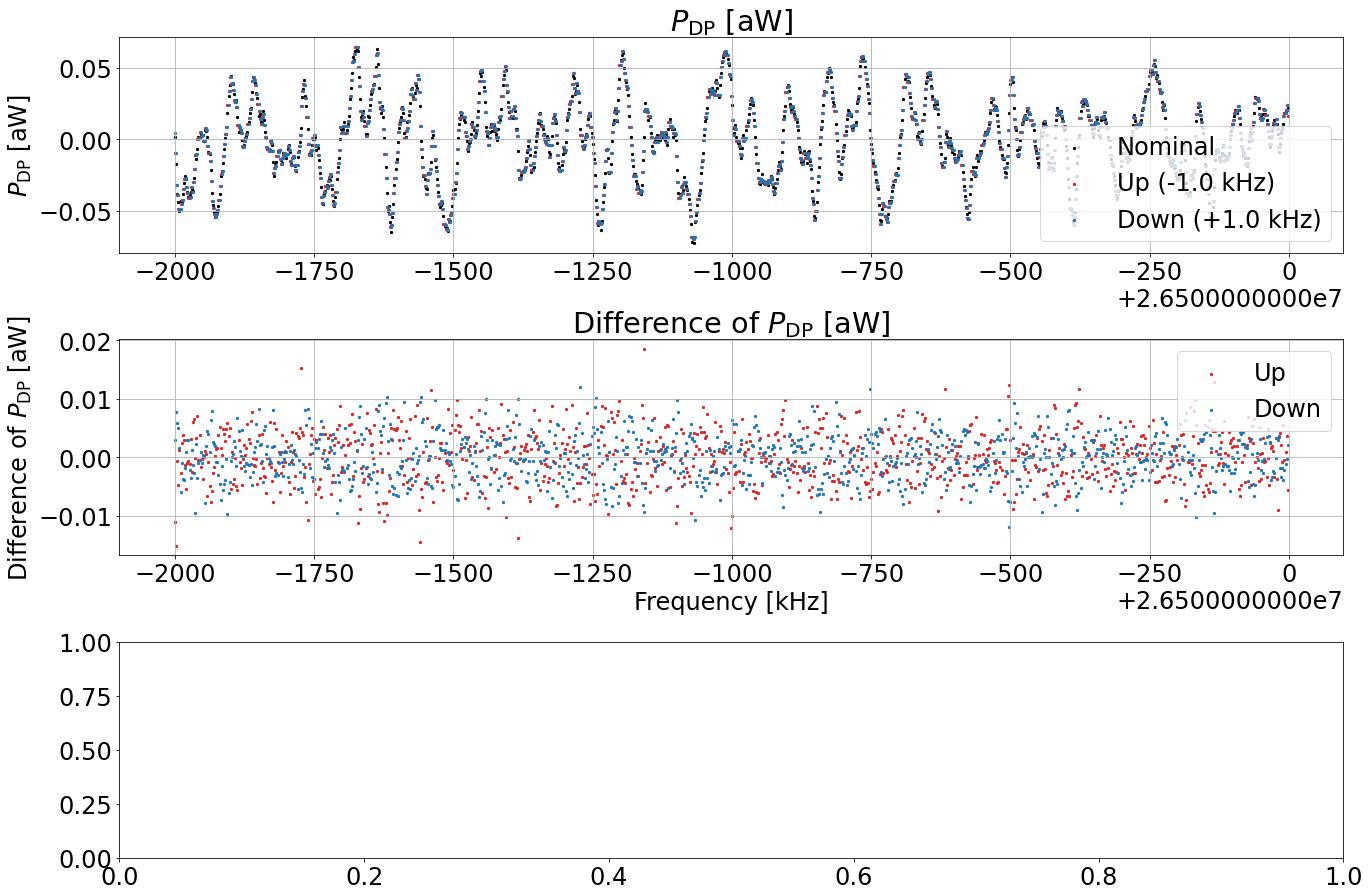

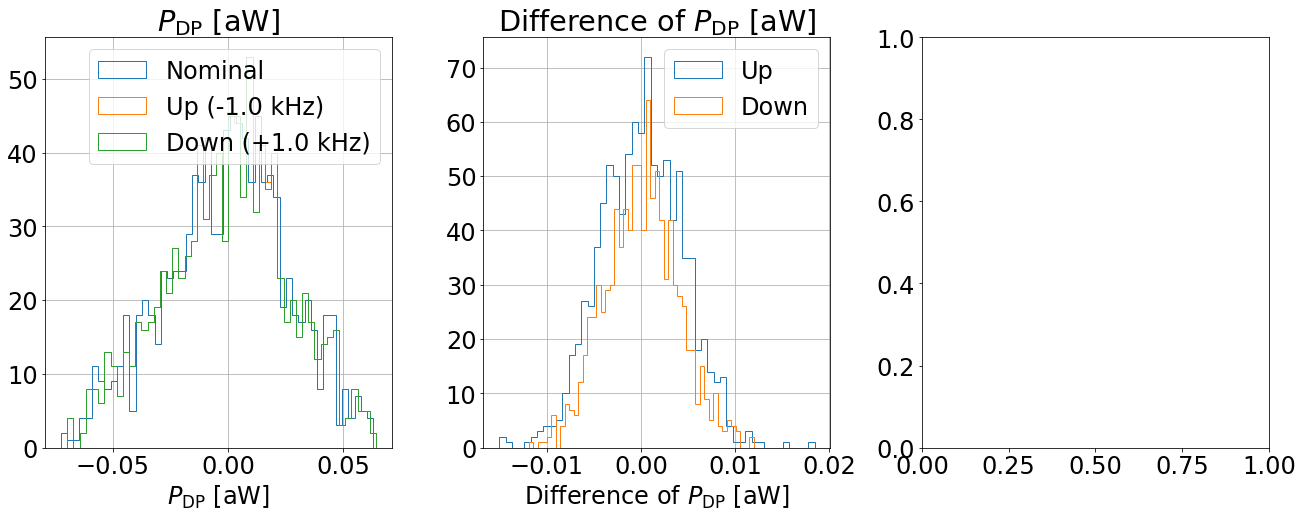

In [17]:
err_P_DP2 = check_variation_freq0(freq2, nom2, up2, down2)
print(f'Error of P_DP = {err_P_DP2} aW at {freq2*1-9} GHz')

In [19]:
print(f'Max. error of P_DP = {max([err_P_DP, err_P_DP2])} W')

Max. error of P_DP = 4.1276142503614574e-21 W


## Check fit variation by changing the peak frequency in simulation

In [93]:
fit_before_span = 50.e+3
fit_after_span = 150.e+3
bin_width = 2.e+3

def get_signalsimulation(freq, P, freq_0):
    '''
    freq: frequency array [Hz]
    P: Power of signal [W]
    freq_0: signal peak frequency [Hz]
    '''
    signal = fit.fit_func(freq, a=0, b=0, P=P, freq_0=freq_0)
    return signal

def fit_1point(freq, W, Werr, freq_0):
    params = lmfit.Parameters()
    params.add('a', value=1.)
    params.add('b', value=1.)
    params.add('P', value=1.)
    #print(freq, W, Werr, freq_0)
    result = lmfit.minimize(fit.residual, params, args=(freq, W, Werr, freq_0))
    return result

def fit_on_signal(P, freq_0, dfreq_0=0., verbose=1):
    '''
    P: Power of DP signal [W]
    freq_0: Peak frequency of DP signal [Hz]
    dfreq_0: variation of the peak frequency (fitted freq array will not varied by this.) [Hz]
    '''
    freq = np.arange(freq_0-fit_before_span, freq_0+fit_after_span, bin_width)
    signal = get_signalsimulation(freq, P, freq_0+dfreq_0)
    signal_err = np.full(len(freq), 1.)
    #signal_err = np.full(len(freq), P*0.01)
    
    result = fit_1point(freq, signal, signal_err, freq_0)
    
    result_dict = {'freq_0':0, 'a':0, 'b':0, 'P':0, 'a_err':0, 'b_err':0, 'P_err':0, 'redchi':0, 'success':0}
    result_dict['freq_0'] = (freq_0)
    result_dict['a'] = (result.params["a"].value) 
    result_dict['b'] = (result.params["b"].value) 
    result_dict['P'] = (result.params["P"].value)
    result_dict['a_err'] = (result.params["a"].stderr)  
    result_dict['b_err'] = (result.params["b"].stderr)
    result_dict['P_err'] = (result.params["P"].stderr)
    result_dict['redchi'] = (result.redchi)
    result_dict['success'] = (result.success)
    
    if verbose > 0:
        print(f'    P_DP = {result_dict["P"]} +0 {result_dict["P_err"]} W')
        print(f'    redchi = {result_dict["redchi"]}')
        print(f'    success = {result_dict["success"]}')
        pass
    
    return result_dict

In [94]:
# dfreq_0 = 1e+3 # 1kHz = half of bin width
def check_P_DP_vary(freq_0=18.e+9, P_0=1.e-18, verbose=0, dfreq_0=1e+3):
    result = fit_on_signal(P=P_0, freq_0=freq_0, dfreq_0=0., verbose=verbose)
    result_up   = fit_on_signal(P=P_0, freq_0=freq_0, dfreq_0=dfreq_0, verbose=verbose)
    result_down = fit_on_signal(P=P_0, freq_0=freq_0, dfreq_0=-dfreq_0, verbose=verbose)

    P = result['P']
    P_up = result_up['P']
    P_down = result_down['P']

    diff_up = P_up - P
    diff_down = P_down - P
    diff_ave = (np.abs(diff_up) + np.abs(diff_down))/2.

    diffratio_up = diff_up/P
    diffratio_down = diff_down/P
    diffratio_ave = diff_ave/P

    if verbose > 0:
        print(f'Diff. ratio up = {diffratio_up*100:.3f} %')
        print(f'Diff. ratio down = {diffratio_down*100:.3f} %')
        print(f'Diff. ratio ave = {diffratio_ave*100:.3f} %')
        pass
    return diffratio_ave

In [95]:

freq_0_array = np.arange(18., 27., 0.5) * 1.0e+9
diffratio_list = []
for _freq_0 in freq_0_array:
    print(f'** Peak frequency = {_freq_0*1e-9:.2f} GHz **')
    _diffratio = check_P_DP_vary(_freq_0, 1.e-18, verbose=0)
    diffratio_list.append(_diffratio)
    print(f'Diff. ratio (P=1e-18 W) = {_diffratio*100:f} %')
    _diffratio = check_P_DP_vary(_freq_0, 1., verbose=0)
    diffratio_list.append(_diffratio)
    print(f'Diff. ratio (P=1 W) = {_diffratio*100:f} %')
    pass

max_diffratio = max(diffratio_list)
print(f'*********************')
print(f'Max. diff. ratio = {max_diffratio*100:f} %')
print(f'*********************')

** Peak frequency = 18.00 GHz **
Diff. ratio (P=1e-18 W) = 1.191656 %
Diff. ratio (P=1 W) = 1.191657 %
** Peak frequency = 18.50 GHz **
Diff. ratio (P=1e-18 W) = 1.149135 %
Diff. ratio (P=1 W) = 1.149135 %
** Peak frequency = 19.00 GHz **
Diff. ratio (P=1e-18 W) = 1.109117 %
Diff. ratio (P=1 W) = 1.109116 %
** Peak frequency = 19.50 GHz **
Diff. ratio (P=1e-18 W) = 1.071407 %
Diff. ratio (P=1 W) = 1.071409 %
** Peak frequency = 20.00 GHz **
Diff. ratio (P=1e-18 W) = 1.035827 %
Diff. ratio (P=1 W) = 1.035827 %
** Peak frequency = 20.50 GHz **
Diff. ratio (P=1e-18 W) = 1.002212 %
Diff. ratio (P=1 W) = 1.002213 %
** Peak frequency = 21.00 GHz **
Diff. ratio (P=1e-18 W) = 0.970418 %
Diff. ratio (P=1 W) = 0.970419 %
** Peak frequency = 21.50 GHz **
Diff. ratio (P=1e-18 W) = 0.940307 %
Diff. ratio (P=1 W) = 0.940308 %
** Peak frequency = 22.00 GHz **
Diff. ratio (P=1e-18 W) = 0.911764 %
Diff. ratio (P=1 W) = 0.911766 %
** Peak frequency = 22.50 GHz **
Diff. ratio (P=1e-18 W) = 0.884675 %
Dif